In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time


from sklearn.model_selection import train_test_split


import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.callbacks import LearningRateScheduler
from keras.metrics import RootMeanSquaredError

In [2]:
df = pd.read_csv("Elrond.csv")
df.fillna(method= 'ffill')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns='Currency', axis=1, inplace=True)

In [3]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [4]:
def Dataset(Data, Date, X_scaler, y_scaler):

  index = Data.index[Data['Date'] == Date][0]
  X = Data.drop(columns=['Date', 'Close'], axis=1).to_numpy()
  y = Data['Close'].to_numpy()

  X = X_scaler.fit_transform(np.array(X))
  y = y_scaler.fit_transform(np.array(y).reshape(-1,1))
  
  X_train = X[:index]
  y_train = y[:index]
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  X_test = X[index:]
  y_test = y[index:]
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  return X_train, y_train, X_test, y_test

# LSTM Model

In [5]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

# EGLD

In [10]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = Dataset(df, date, X_scaler, y_scaler)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((515, 4, 1), (515, 1), (63, 4, 1), (63, 1))

In [25]:
np.random.seed(42)
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = mean_squared_error#'mse'
dropout = 0.2
optimizer = 'adam'

In [26]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
egld_hist = egld_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


NotImplementedError: in user code:

    File "c:\Anaconda\envs\projet_pite\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Anaconda\envs\projet_pite\lib\site-packages\sklearn\metrics\_regression.py", line 437, in mean_squared_error  *
        y_type, y_true, y_pred, multioutput = _check_reg_targets(
    File "c:\Anaconda\envs\projet_pite\lib\site-packages\sklearn\metrics\_regression.py", line 94, in _check_reg_targets  *
        check_consistent_length(y_true, y_pred)
    File "c:\Anaconda\envs\projet_pite\lib\site-packages\sklearn\utils\validation.py", line 330, in check_consistent_length  *
        uniques = np.unique(lengths)
    File "<__array_function__ internals>", line 180, in unique  **
        
    File "c:\Anaconda\envs\projet_pite\lib\site-packages\numpy\lib\arraysetops.py", line 270, in unique
        ar = np.asanyarray(ar)

    NotImplementedError: Cannot convert a symbolic Tensor (mean_squared_error/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [19]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

KeyError: 'root_mean_squared_error'

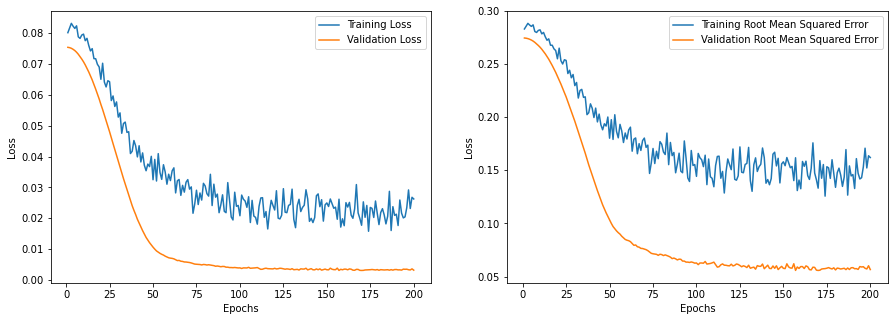

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [20]:
# make predictions
egld_prediction = model.predict(X_test)

# invert predictions

# create empty table with 4 fields
egld_prediction_dataset_like = np.zeros(shape=(len(egld_prediction), 4))
# put the predicted values in the right field
egld_prediction_dataset_like[:,0] = egld_prediction[:,0]
# inverse transform and then select the right field
egld_prediction = X_scaler.inverse_transform(egld_prediction_dataset_like)[:,0]
egld_prediction = egld_prediction.reshape(-1,1)

trainY = y_scaler.inverse_transform(y_train)
testY = y_scaler.inverse_transform(y_test)

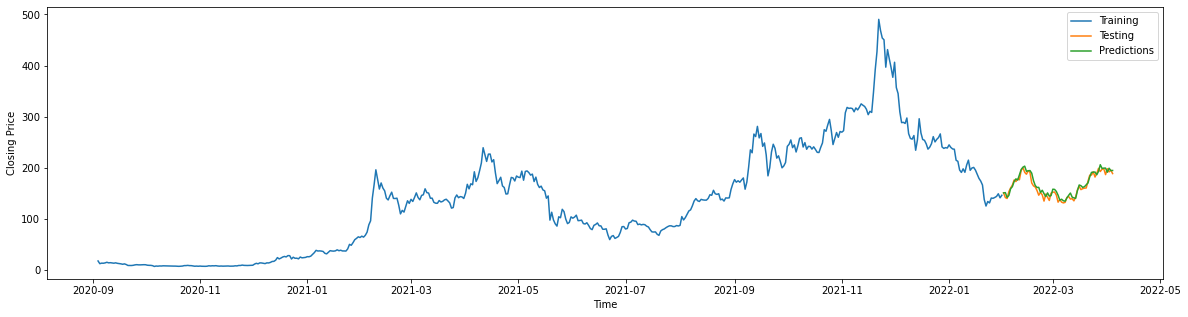

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(df['Date'][df['Date'] < date], trainY, label = 'Training')
plt.plot(df['Date'][df['Date'] >= date], testY, label = 'Testing')
plt.plot(df['Date'][df['Date'] >= date], egld_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

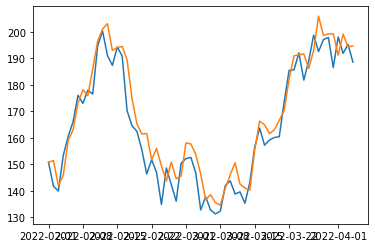

In [22]:
plt.plot(df['Date'][df['Date'] >= date], df['Close'][df['Date'] >= date], label = 'Testing')
plt.plot(df['Date'][df['Date'] >= date], egld_prediction, label = 'Predictions')